Create an input file, read or generate the corresponding netcdf simulation file in our database and create a simple plot

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import subprocess # to capture errors from the simulations
import yaml
import pandas as pd

First let us inspect the database class for an overview of how it works

In [2]:
help(simplesim)

Help on module simplesimdb:

NAME
    simplesimdb - Creation and management of simple simulation data

CLASSES
    builtins.object
        Manager
        Repeater
    
    class Manager(builtins.object)
     |  Manager(directory='./data', filetype='nc', executable='./execute.sh')
     |  
     |  Lightweight Simulation Database Manager
     |  
     |  Create, access and display simulation data of a given code as pairs
     |  (inputfile.json : outputfile [, restarted_01, restarted_02, ...]),
     |  where all input is given by python dictionaries (stored as json files)
     |  and the output files (of arbitrary type) are generated by an executable
     |  that takes the json file as input. This executable is provided by the user.
     |  
     |  NOTE: an executable may only take one sinlge input file and may only
     |      generate one single output file (except for RESTART, see below)
     |  NOTE: the executable can be a bash script. For example if the actual program
     |     

Now, let us generate an input file for impurities_hpc.
Read more about the various parameters in the corresponding impurities.pdf documentation

In [3]:
# BE CAREFUL: the inputfile should be very strict on input types,
# i.e. 
# DO NOT WRITE 3.0 INTO A FIELD REQUIRING AN INTEGER
# AND VICE VERSA 10 INTO A FIELD REQUIRING A FLOAT
# else our database manager will treat it as a new entry
inputfile={
    "grid" :
    {
        "n"  : 3,
        "Nx" : 128,
        "Ny" : 128,
        "x" : [0, 200],
        "y" : [0, 200]
    },
    "output":
    {
        "type" : "netcdf",
        "tend" : 1500,
        "maxout" : 50,
        "itstp" : 4,
        "n"  : 3,
        "Nx" : 64,
        "Ny" : 64
    },
    "elliptic":
    {
        "stages" : 3,
        "eps_pol" : [1e-6, 0.5, 0.5],
        "eps_gamma" : [1e-8, 1, 1],
        "direction" : "forward"
    },
    "timestepper":
    {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-6,
        "atol" : 1e-7,
        "reject-limit" : 2
    },
    "curvature" : 0.000457,
    "potential":
    {
        "epsilon_D" : 0,
        "bc" : ["DIR", "PER"]
    },
    "species":
    [
        {
            "name" : "e",
            "mu" : 0,
            "tau" : -1,
            "a" : -1,
            "nu_perp" : 0, # 1e-5
            "bc" : ["DIR", "PER"],
            "init":
            {
                "type" : "zero_potential"
            }
        },
        {
            "name" : "i",
            "mu" : 1,
            "tau" : 0.0,
            "a" : 0.999,
            "nu_perp" : 0, # 1e-5
            "bc" : ["DIR", "PER"],
            "init":
            {
                "type" : "blob",
                "amplitude" : 1,
                "posX" : 0.5,
                "posY" : 0.5,
                "sigma" : 10,
                "flr" : "gamma_inv"
            },
        },
        {
            "name" : "j",
            "mu" : 2,
            "tau" : 0.0,
            "a" : 0.001,
            "nu_perp" : 0, # 1e-5
            "bc" : ["DIR", "PER"],
            "init":
            {
                "type" : "blob",
                "amplitude" : 1,
                "posX" : 0.5,
                "posY" : 0.5,
                "sigma" : 10,
                "flr" : "gamma_inv"
            }
        }
    ]
}

Create a Database in the data folder

In [4]:
m = simplesim.Manager(directory='data', executable='./execute.sh', filetype='nc')
# Let's see what id the database allocates to our input
print(m.jsonfile(inputfile))

data/7813a2f0e0f2e5dfdb99a3e0ffa7e3ea08e24a6e.json


Now we have to either run the simulation or simply read the output data if it is already available in our data base

In [5]:
# Takes about a minute ...
ncfile=m.recreate(inputfile, error = "display")
print( ncfile)

Running simulation 7813a2...e24a6e.nc
data/7813a2f0e0f2e5dfdb99a3e0ffa7e3ea08e24a6e.nc


Let's print the metadata in the netcdf file to see what is inside

In [6]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    elif v == "diag_time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (51,)
y (192,) 	y-coordinate in Computational coordinate system
x (192,) 	x-coordinate in Computational coordinate system
diag_time (201,)
X_e (201,) 	Center of mass X position for species e
Y_e (201,) 	Center of mass Y position for species e
M1d_e (201,) 	 N_s integral for species e
S1d_e (201,) 	 a_s tau_s N ln N integral for species e
U1d_e (201,) 	 0.5 a_s mu_s N u_E^2 integral for species e
n_e (51, 192, 192) 	Real density in 2d for species e
gy_e (51, 192, 192) 	Gyro-center density in 2d for species e
psi_e (51, 192, 192) 	Gyro-center potential for species e
vor_e (51, 192, 192) 	Gyro-center vorticity for species e
S_e (51, 192, 192) 	 a_s tau_s N ln N for species e
U_e (51, 192, 192) 	 0.5 a_s mu_s N u_E^2 for species e
X_i (201,) 	Center of mass X position for species i
Y_i (201,) 	Center of mass Y position for species i
M1d_i (201,) 	 N_s integral for species i
S1d_i (201,) 	 a_s tau_s N ln N integral for species i
U1d_i (201,) 	 0.5 a_s mu_s N u_E^2 integra

Now we can plot the content. (MW: Maybe investigate why for n=3 the blob looses its up-down symmetry and for n=4 it does not)

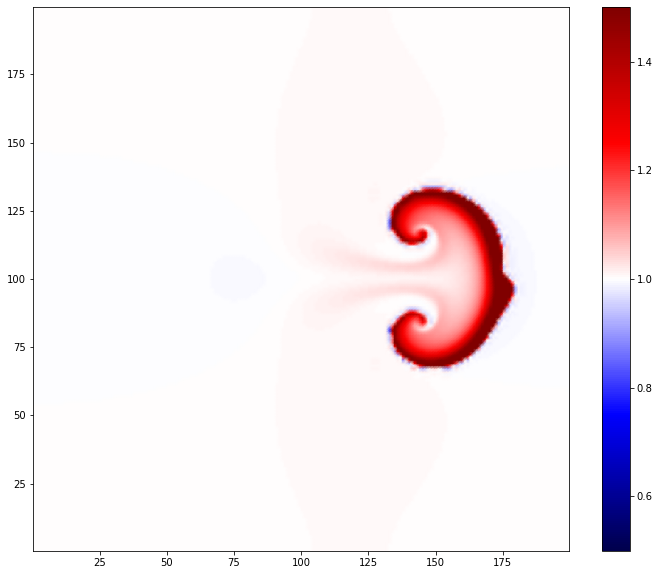

In [7]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
vo = ncin["n_e"][:,:,:]
po = ncin["psi_e"][:,:,:]
time = ncin["time"][:]
plt.figure(figsize=(12, 10))
plt.pcolormesh(xc,yc,vo[-1,:,:],
               shading='gouraud',
               cmap = 'seismic', vmin = 0.5, vmax = 1.5 )
plt.colorbar()
#plt.axis('scaled')
plt.show()

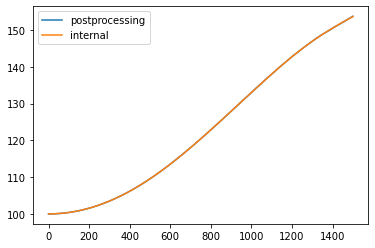

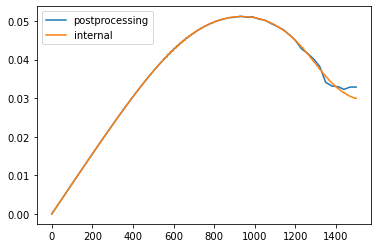

postprocessing: Vmax =  0.05124078790786015  vs internal: Vmax =  0.05116661474802974
Relative difference  0.0014496397738188412


In [16]:
#  plot center of mass velocity
weights= ncin["weights"][:,:]
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
time = ncin["time"][:]
n_e = ncin["n_e"][:,:,:]

diag_time = ncin["diag_time"][:]
com_e = ncin["X_e"][:]

total_blob_mass = np.sum( (n_e-1)*weights, axis=(1,2) )
com = np.sum( (n_e-1)*xc*weights, axis=(1,2))/total_blob_mass
plt.plot( time, com, label='postprocessing' )
plt.plot( diag_time, com_e, label = 'internal' )
plt.legend(loc="upper left")
plt.show()
# Compute centered differences of com to get com velocity

# vel
centered = [-1,0,1]
dcom  = np.convolve( com, centered,'valid')
dtime = np.convolve( time, centered, 'valid')
vel = dcom/dtime
vel = np.append( 0, vel)
vel = np.append( vel, vel[-1] )

plt.plot( time, vel, label='postprocessing' )

dcom_e  = np.convolve( com_e, centered,'valid')
dtime_e = np.convolve( diag_time, centered, 'valid')
vel_e = dcom_e/dtime_e
vel_e = np.append( 0, vel_e)
vel_e = np.append( vel_e, vel_e[-1] )
plt.plot( diag_time, vel_e, label = 'internal' )
plt.legend(loc="upper left")
plt.show()
print( "postprocessing: Vmax = ", max( vel), " vs internal: Vmax = ", max(vel_e))
print( "Relative difference ", (max(vel)-max(vel_e))/max(vel_e))

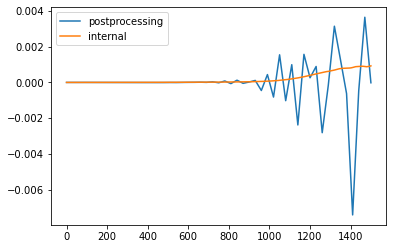

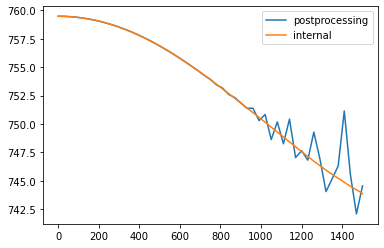

In [15]:
# Misses 
S_e = ncin["S_e"][:,:,:]
S_i = ncin["S_i"][:,:,:]
U_e = ncin["U_e"][:,:,:]
U_i = ncin["U_i"][:,:,:]
S1d_e = ncin["S1d_e"][:]
S1d_i = ncin["S1d_i"][:]
U1d_e = ncin["U1d_e"][:]
U1d_i = ncin["U1d_i"][:]
total_energy = np.sum( (S_e + S_i + U_e + U_i)*weights, axis=(1,2) )
total_energy_int = S1d_e + S1d_i + U1d_e + U1d_i
# plot accuracy of energy
plt.plot( time, (total_energy[0]-total_energy)/total_energy[0], label='postprocessing')
plt.plot( diag_time, (total_energy_int[0]-total_energy_int)/total_energy_int[0], label='internal')
plt.legend()
plt.show()
plt.plot( time, np.sum(S_e*weights, axis=(1,2)), label='postprocessing')
plt.plot( diag_time, S1d_e, label='internal')
plt.legend()
plt.show()

In [10]:
# Analyse performance of simulations
outfiles = simplesim.Manager(directory='data', executable='./execute.sh', filetype='out')

In [11]:
outfile = outfiles.outfile( inputfile)
output = yaml.full_load(open(outfile))
# print( output)
df = pd.json_normalize(output['timeloop'])
df.set_index('time',inplace=True)
print( "Total  time ", output['total-time'])
print( "Output time ", output['output-time'])
print( "Number rhs  ", output['ncalls'])
df.tail()

Total  time  129.355
Output time  2.18178
Number rhs   1390


,gammaNe,gammaNi,gammaNj,pol,psie,psii,psij,rhse,rhsi,rhsj,total
time,,,,,,,,,,,
1499.42,0.000031,0.000028,0.000028,0.163797,0.000072,0.000028,0.000027,0.000152,0.000143,0.000143,0.164527
1499.88,0.000031,0.000028,0.000028,0.128008,0.000078,0.000032,0.000054,0.000155,0.000144,0.000148,0.128799
1499.94,0.000031,0.000028,0.000028,0.026515,0.000071,0.000028,0.000027,0.000150,0.000142,0.000142,0.027250
1499.97,0.000031,0.000027,0.000028,0.008576,0.000073,0.000030,0.000028,0.000166,0.000153,0.000155,0.009737
1500,0.000031,0.000027,0.000027,0.007569,0.000071,0.000028,0.000027,0.000151,0.000142,0.000144,0.008303


In [12]:
dff = df.drop('total',axis=1)
# df['total'].mean()
dff.mean() / df['total'].mean()

gammaNe    0.000365
gammaNi    0.000322
gammaNj    0.000317
pol        0.990932
psie       0.000816
psii       0.000322
psij       0.000315
rhse       0.001726
rhsi       0.001625
rhsj       0.001627
dtype: float64